# This is the script to implement the unified evaluation metrics toward the PanFormer segmentation results of our own waymo dataset. The seg results from Panformer are the RGB images with objects masked in different color. Please refer to /utils/metrics.py for the description of our metrics.

In [1]:
import os
import cv2
import json, yaml
import torch
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

In [29]:
seg_day_fair_path = '/home/autolab/Data/seg_day_fair/'
gt_day_fair_path = '/home/autolab/workspace/Panoptic-SegFormer/datasets/waymo_panformer/test_day_fair_anno_rgb/'

In [33]:
seg_day_rain_path = '/home/autolab/Data/seg_day_rain/'
gt_day_rain_path = '/home/autolab/workspace/Panoptic-SegFormer/datasets/waymo_panformer/test_day_rain_anno_rgb/'

In [44]:
seg_night_rain_path = '/home/autolab/Data/seg_night_rain/'
gt_night_rain_path = '/home/autolab/workspace/Panoptic-SegFormer/datasets/waymo_panformer/test_night_rain_anno_rgb/'

In [41]:
seg_night_fair_path = '/home/autolab/Data/seg_night_fair/'
gt_night_fair_path = '/home/autolab/workspace/Panoptic-SegFormer/datasets/waymo_panformer/test_night_fair_anno_rgb/'

In [36]:
paths_seg_day_fair = glob(os.path.join(seg_day_fair_path + '*' + '.png'))
paths_anno_day_fair = glob(os.path.join(gt_day_fair_path + '*' + '.png'))

In [37]:
paths_seg_day_rain = glob(os.path.join(seg_day_rain_path + '*' + '.png'))
paths_anno_day_rain = glob(os.path.join(gt_day_rain_path + '*' + '.png'))

In [42]:
paths_seg_night_fair = glob(os.path.join(seg_night_fair_path + '*' + '.png'))
paths_anno_night_fair = glob(os.path.join(gt_night_fair_path + '*' + '.png'))

In [45]:
paths_seg_night_rain = glob(os.path.join(seg_night_rain_path + '*' + '.png'))
paths_anno_night_rain = glob(os.path.join(gt_night_rain_path + '*' + '.png'))
print(paths_anno_day_fair)

['/home/autolab/workspace/Panoptic-SegFormer/datasets/waymo_panformer/test_day_fair_anno_rgb/segment-13182548552824592684_4160_250_4180_250_with_camera_labels_0000000176.png', '/home/autolab/workspace/Panoptic-SegFormer/datasets/waymo_panformer/test_day_fair_anno_rgb/segment-12581809607914381746_1219_547_1239_547_with_camera_labels_0000000094.png', '/home/autolab/workspace/Panoptic-SegFormer/datasets/waymo_panformer/test_day_fair_anno_rgb/segment-14940138913070850675_5755_330_5775_330_with_camera_labels_0000000031.png', '/home/autolab/workspace/Panoptic-SegFormer/datasets/waymo_panformer/test_day_fair_anno_rgb/segment-16470190748368943792_4369_490_4389_490_with_camera_labels_0000000186.png', '/home/autolab/workspace/Panoptic-SegFormer/datasets/waymo_panformer/test_day_fair_anno_rgb/segment-7447927974619745860_820_000_840_000_with_camera_labels_0000000042.png', '/home/autolab/workspace/Panoptic-SegFormer/datasets/waymo_panformer/test_day_fair_anno_rgb/segment-15533468984793020049_800_00

## This is the example to compute the IoU for one single input image. 

### The Panformer is based on the COCO dataset. COCO dataset has a lot of classes and assign a rgb color to each class. Our own waymo dataset only contains four classes:  <span style="color:red;">background (id:1), , vehicle (id:2), human (id:3), and ignore(id:4)> </span>. 

### For coco standard, the rgb color assigned to id 1 to 4 is like this:
{
    "supercategory": "person",
    "color": [
      220,
      20,
      60
    ],
    "isthing": 1,
    <span style="color:red;">"id": 1> </span>
    "name": "person"
  },
  {
    "supercategory": "vehicle",
    "color": [
      119,
      11,
      32
    ],
    "isthing": 1,
    <span style="color:red;">"id": 2> </span>
    "name": "bicycle"
  },
  {
    "supercategory": "vehicle",
    "color": [
      0,
      0,
      142
    ],
    "isthing": 1,
    <span style="color:red;">"id": 3> </span>
    "name": "car"
  },
  {
    "supercategory": "vehicle",
    "color": [
      0,
      0,
      230
    ],
    "isthing": 1,
    <span style="color:red;">"id": 4> </span>
    "name": "motorcycle"
  },|

### Regardless the 'name' and 'supercategory' written above, PanFormer code based on 'id' to assign the color for seg visuzlized result.  So in our result it will be [119, 11, 32] for our vehicle class (id:2) and [0, 0, 142] for our human class (id:3).

### For pillow convert('F'), <span style="color:red;">it will convert [119, 11, 32] to 45 and [0, 0, 142] to 16 </span>. For simpilicity, we will use 45 and 16 directly in this notebook to calculate the metric results.

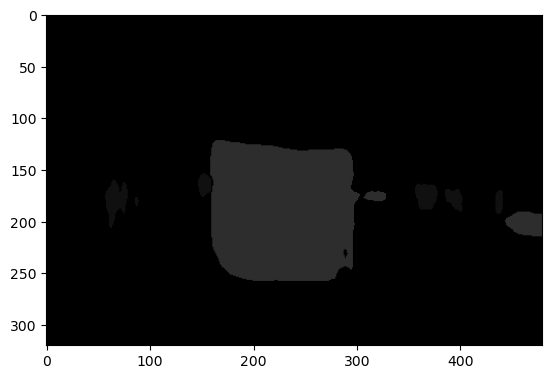

In [56]:
seg_example = Image.open(paths_seg_day_rain[44]).convert('F') 
seg = np.array(seg_example).astype(int)   # here the array only has 0, 45 and 16. 
plt.imshow(seg_example)

In [57]:
anno_example = Image.open(paths_anno_day_rain[44]).convert('F')
anno =np.array(anno_example) # Here contains 0, 1, 2 and 3.
print('anno in array is like:\n', anno)

anno in array is like:
 [[3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 ...
 [3. 3. 0. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]]


In [58]:
seg[anno == 3] = 0
seg[seg == 45] = 1
seg[seg == 16] = 2

In [59]:
overlap = seg*(seg==anno)

<span style="color:red;">Numpy histogram use 'right-most' rule. Will be four bins here [0,1), [1,2), [2,3) and [3,4]. We only take second (1) and third (2) bar for vehcile and human class</span>

In [60]:
area_overlap, _ = np.histogram(overlap, bins=[0, 1, 2, 3, 4])
print('area_overlap:', area_overlap)
print(f'overlap area for vehcile and human is {area_overlap[1]} and {area_overlap[2]}')

area_overlap: [138123  14054   1423      0]
overlap area for vehcile and human is 14054 and 1423


In [61]:
area_pred, _ = np.histogram(seg, bins=[0, 1, 2, 3, 4])
area_anno, _ = np.histogram(anno, bins=[0, 1, 2, 3, 4])

In [62]:
print('area_pres:', area_pred)
print(f'prediction area for vehcile and human is {area_pred[1]} and {area_pred[2]}')

area_pres: [137818  14183   1599      0]
prediction area for vehcile and human is 14183 and 1599


In [63]:
print('area_anno:', area_anno)
print(f'annotation area for vehcile and human is {area_anno[1]} and {area_anno[2]}')

area_anno: [38501 15033  1956 98110]
annotation area for vehcile and human is 15033 and 1956


In [64]:
area_union = area_pred + area_anno - area_overlap
print('area_union:', area_union)
print(f'union area for vehcile and human is {area_union[1]} and {area_union[2]}')

area_union: [38196 15162  2132 98110]
union area for vehcile and human is 15162 and 2132


In [65]:
print(f'IoU of vehicle and human is {area_overlap[1] / area_union[1]} and {area_overlap[2] / area_union[2]}')

IoU of vehicle and human is 0.9269225695818494 and 0.6674484052532833


## Here we will compute cumulative IoU, also precision and recall for all day_rain seg result.

In [31]:
def find_overlap(seg, anno): # seg and anno should be in array integer
    seg[anno == 3] = 0
    seg[seg == 45] = 1
    seg[seg == 16] = 2

    overlap = seg*(seg==anno)
    
    area_overlap, _ = np.histogram(overlap, bins=[0, 1, 2, 3, 4])
    area_pred, _ = np.histogram(seg, bins=[0, 1, 2, 3, 4])
    area_anno, _ = np.histogram(anno, bins=[0, 1, 2, 3, 4])
    area_union = area_pred + area_anno - area_overlap


    assert (area_overlap[1] <= area_anno[1]).all(), "Intersection area should be smaller than Union area"
    assert (area_overlap[2] <= area_anno[2]).all(), "Intersection area should be smaller than Union area"

    return area_overlap, area_pred, area_anno, area_union

In [32]:
overlap_cum, pred_cum, anno_cum, union_cum = 0, 0, 0, 0

for idx in range(len(paths_seg_day_fair)):
    seg_img = Image.open(paths_seg_day_fair[idx]).convert('F')
    anno_img = Image.open(paths_anno_day_fair[idx]).convert('F')

    seg_array = np.array(seg_img).astype(int) 
    anno_array = np.array(anno_img).astype(int) 
    overlap_idx, pred_idx, anno_idx, union_idx = find_overlap(seg_array, anno_array)
    
    overlap_cum += overlap_idx
    pred_cum += pred_idx
    anno_cum += anno_idx
    union_cum += union_idx

cum_IoU = overlap_cum[1:3] / union_cum[1:3]
cum_precision = overlap_cum[1:3] / pred_cum[1:3]
cum_recall = overlap_cum[1:3] / anno_cum[1:3]
print(f'Test result for DAY-FAIR\n'
      f'VEHICLE:CUM_IoU->{cum_IoU[0]:.4f}, CUM_Precision->{cum_precision[0]:.4f}, CUM_Recall->{cum_recall[0]:.4f} \n'
      f'HUMAN: CUM_IoU->{cum_IoU[1]:.4f}, CUM_Precision->{cum_precision[1]:.4f}, CUM_Recall->{cum_recall[1]:.4f}')

Test result for DAY-FAIR
VEHICLE:CUM_IoU->0.6641, CUM_Precision->0.8928, CUM_Recall->0.7216 
HUMAN: CUM_IoU->0.4078, CUM_Precision->0.6851, CUM_Recall->0.5018


In [40]:
overlap_cum, pred_cum, anno_cum, union_cum = 0, 0, 0, 0

for idx in range(len(paths_seg_day_rain)):
    seg_img = Image.open(paths_seg_day_rain[idx]).convert('F')
    anno_img = Image.open(paths_anno_day_rain[idx]).convert('F')

    seg_array = np.array(seg_img).astype(int) 
    anno_array = np.array(anno_img).astype(int) 
    overlap_idx, pred_idx, anno_idx, union_idx = find_overlap(seg_array, anno_array)
    
    overlap_cum += overlap_idx
    pred_cum += pred_idx
    anno_cum += anno_idx
    union_cum += union_idx

cum_IoU = overlap_cum[1:3] / union_cum[1:3]
cum_precision = overlap_cum[1:3] / pred_cum[1:3]
cum_recall = overlap_cum[1:3] / anno_cum[1:3]
print(f'Test result for DAY-RAIN\n'
      f'VEHICLE:CUM_IoU->{cum_IoU[0]:.4f}, CUM_Precision->{cum_precision[0]:.4f}, CUM_Recall->{cum_recall[0]:.4f} \n'
      f'HUMAN: CUM_IoU->{cum_IoU[1]:.4f}, CUM_Precision->{cum_precision[1]:.4f}, CUM_Recall->{cum_recall[1]:.4f}')

Test result for DAY-RAIN
VEHICLE:CUM_IoU->0.6307, CUM_Precision->0.9111, CUM_Recall->0.6720 
HUMAN: CUM_IoU->0.2987, CUM_Precision->0.6681, CUM_Recall->0.3507


In [43]:
overlap_cum, pred_cum, anno_cum, union_cum = 0, 0, 0, 0

for idx in range(len(paths_seg_night_fair)):
    seg_img = Image.open(paths_seg_night_fair[idx]).convert('F')
    anno_img = Image.open(paths_anno_night_fair[idx]).convert('F')

    seg_array = np.array(seg_img).astype(int) 
    anno_array = np.array(anno_img).astype(int) 
    overlap_idx, pred_idx, anno_idx, union_idx = find_overlap(seg_array, anno_array)
    
    overlap_cum += overlap_idx
    pred_cum += pred_idx
    anno_cum += anno_idx
    union_cum += union_idx

cum_IoU = overlap_cum[1:3] / union_cum[1:3]
cum_precision = overlap_cum[1:3] / pred_cum[1:3]
cum_recall = overlap_cum[1:3] / anno_cum[1:3]
print(f'Test result for NIGHT-FAIR\n'
      f'VEHICLE:CUM_IoU->{cum_IoU[0]:.4f}, CUM_Precision->{cum_precision[0]:.4f}, CUM_Recall->{cum_recall[0]:.4f} \n'
      f'HUMAN: CUM_IoU->{cum_IoU[1]:.4f}, CUM_Precision->{cum_precision[1]:.4f}, CUM_Recall->{cum_recall[1]:.4f}')

Test result for NIGHT-FAIR
VEHICLE:CUM_IoU->0.7025, CUM_Precision->0.9079, CUM_Recall->0.7564 
HUMAN: CUM_IoU->0.3869, CUM_Precision->0.6707, CUM_Recall->0.4776


In [46]:
overlap_cum, pred_cum, anno_cum, union_cum = 0, 0, 0, 0

for idx in range(len(paths_seg_night_rain)):
    seg_img = Image.open(paths_seg_night_rain[idx]).convert('F')
    anno_img = Image.open(paths_anno_night_rain[idx]).convert('F')

    seg_array = np.array(seg_img).astype(int) 
    anno_array = np.array(anno_img).astype(int) 
    overlap_idx, pred_idx, anno_idx, union_idx = find_overlap(seg_array, anno_array)
    
    overlap_cum += overlap_idx
    pred_cum += pred_idx
    anno_cum += anno_idx
    union_cum += union_idx

cum_IoU = overlap_cum[1:3] / union_cum[1:3]
cum_precision = overlap_cum[1:3] / pred_cum[1:3]
cum_recall = overlap_cum[1:3] / anno_cum[1:3]
print(f'Test result for NIGHT-RAIN\n'
      f'VEHICLE:CUM_IoU->{cum_IoU[0]:.4f}, CUM_Precision->{cum_precision[0]:.4f}, CUM_Recall->{cum_recall[0]:.4f} \n'
      f'HUMAN: CUM_IoU->{cum_IoU[1]:.4f}, CUM_Precision->{cum_precision[1]:.4f}, CUM_Recall->{cum_recall[1]:.4f}')

Test result for NIGHT-RAIN
VEHICLE:CUM_IoU->0.5440, CUM_Precision->0.8574, CUM_Recall->0.5981 
HUMAN: CUM_IoU->0.3900, CUM_Precision->0.6437, CUM_Recall->0.4973
